# Importing Libraries and Data 

In [2]:
import os 
import time 
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Callable, Optional, Type, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision import datasets

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure all images are 32x32
    transforms.ToTensor(),
])

# Download and create the CIFAR-10 train and test datasets
train_ds = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_ds = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

print(f'Train Samples: {len(train_ds)} || Test Samples: {len(test_ds)} || Classes: {len(train_ds.classes)}')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:04<00:00, 37004083.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Samples: 50000 || Test Samples: 10000 || Classes: 10


# Making the Model

In [4]:
torch.manual_seed(42)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_chans: int, out_chans: int, kernel_size: int, stride: int, padding: int):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_chans, in_chans, kernel_size=kernel_size, stride=stride,
                                   padding=padding, groups=in_chans, bias=False)
        self.pointwise = nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class Classifier(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.fc(x)


class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        self.conv1 = DepthwiseSeparableConv(in_chans=3, out_chans=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = DepthwiseSeparableConv(in_chans=32, out_chans=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = DepthwiseSeparableConv(in_chans=64, out_chans=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # halves the input size
        
        # Assuming 32x32 input
        self.flatten_dim = 128 * 4 * 4 
        self.classifier = Classifier(in_dim=self.flatten_dim, out_dim=num_classes)

    def forward(self, x):
        # Pass through the depthwise separable convolution layers
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 4, 4]

        # Flatten the output from conv layers
        x = x.view(x.size(0), -1)  # Flatten into [batch_size, 128 * 4 * 4]
        x = self.classifier(x)
        
        return x

model = CustomCNN(num_classes=10)

input_image = torch.randn(8, 3, 32, 32)  
output = model(input_image)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([8, 10])


# Training the Model

In [5]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):
       
        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

In [6]:
import torch.optim as optim
import csv
from tqdm import tqdm 
import time as time

torch.manual_seed(42)

model = CustomCNN(num_classes=10)

out_dir = './dw_conv-output'
os.makedirs(out_dir, exist_ok=True)
epochs = 10
lr = 3e-4
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'
model.to(device)

params = count_trainable_params(model)
print(f'Finetuning {params*1e-6:.3f}M params on {device} for {epochs} epochs ...\n')

csv_file = os.path.join(out_dir, 'log.csv')
model_file = os.path.join(out_dir, 'weights.pth')

with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  

        train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = eval_step(model, test_dl, criterion, device)
        
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc])
        
        epoch_duration = time.time() - start_time

        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Val Acc: {val_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")
    
    torch.save(model.state_dict(), model_file)

Finetuning 0.032M params on cuda for 10 epochs ...



Epochs:   0%|           | Epoch: 0/10 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.8442 Acc: 0.3439
Evaluation: [313/313] Loss: 1.6026 Acc: 0.4459

Epochs:  10%|█          | Epoch: 1/10 | Time: 00:11 < 01:43 | 11.51s/it


============ Epoch 1 --> Train Acc: 0.3439 || Val Acc: 0.4459 || Time: 11.51 s ============

Training: [1563/1563] Loss: 1.5388 Acc: 0.4597
Evaluation: [311/313] Loss: 1.4742 Acc: 0.4835

Epochs:  20%|██         | Epoch: 2/10 | Time: 00:22 < 01:27 | 10.92s/it

Evaluation: [313/313] Loss: 1.4733 Acc: 0.4830
============ Epoch 2 --> Train Acc: 0.4597 || Val Acc: 0.4830 || Time: 10.51 s ============

Training: [1563/1563] Loss: 1.4208 Acc: 0.5012
Evaluation: [305/313] Loss: 1.3671 Acc: 0.5226

Epochs:  30%|███        | Epoch: 3/10 | Time: 00:32 < 01:16 | 10.90s/it

Evaluation: [313/313] Loss: 1.3665 Acc: 0.5213
============ Epoch 3 --> Train Acc: 0.5012 || Val Acc: 0.5213 || Time: 10.87 s ============

Training: [1563/1563] Loss: 1.3452 Acc: 0.5287
Evaluation: [309/313] Loss: 1.3001 Acc: 0.5477

Epochs:  40%|████       | Epoch: 4/10 | Time: 00:43 < 01:04 | 10.80s/it

Evaluation: [313/313] Loss: 1.3000 Acc: 0.5463
============ Epoch 4 --> Train Acc: 0.5287 || Val Acc: 0.5463 || Time: 10.65 s ============

Training: [1563/1563] Loss: 1.2914 Acc: 0.5481
Evaluation: [313/313] Loss: 1.2700 Acc: 0.5521

Epochs:  50%|█████      | Epoch: 5/10 | Time: 00:54 < 00:53 | 10.73s/it


============ Epoch 5 --> Train Acc: 0.5481 || Val Acc: 0.5521 || Time: 10.59 s ============

Training: [1563/1563] Loss: 1.2465 Acc: 0.5632
Evaluation: [307/313] Loss: 1.2293 Acc: 0.5698

Epochs:  60%|██████     | Epoch: 6/10 | Time: 01:05 < 00:43 | 10.80s/it

Evaluation: [313/313] Loss: 1.2300 Acc: 0.5692
============ Epoch 6 --> Train Acc: 0.5632 || Val Acc: 0.5692 || Time: 10.92 s ============

Training: [1563/1563] Loss: 1.2092 Acc: 0.5777
Evaluation: [313/313] Loss: 1.2032 Acc: 0.5809

Epochs:  70%|███████    | Epoch: 7/10 | Time: 01:15 < 00:32 | 10.72s/it


============ Epoch 7 --> Train Acc: 0.5777 || Val Acc: 0.5809 || Time: 10.57 s ============

Training: [1563/1563] Loss: 1.1785 Acc: 0.5891
Evaluation: [313/313] Loss: 1.1795 Acc: 0.5856


Epochs:  80%|████████   | Epoch: 8/10 | Time: 01:26 < 00:21 | 10.67s/it

============ Epoch 8 --> Train Acc: 0.5891 || Val Acc: 0.5856 || Time: 10.56 s ============

Training: [1563/1563] Loss: 1.1481 Acc: 0.6001
Evaluation: [312/313] Loss: 1.1571 Acc: 0.5912

Epochs:  90%|█████████  | Epoch: 9/10 | Time: 01:37 < 00:10 | 10.76s/it

Evaluation: [313/313] Loss: 1.1565 Acc: 0.5914
============ Epoch 9 --> Train Acc: 0.6001 || Val Acc: 0.5914 || Time: 10.97 s ============

Training: [1563/1563] Loss: 1.1216 Acc: 0.6100
Evaluation: [313/313] Loss: 1.1588 Acc: 0.5892

Epochs: 100%|██████████ | Epoch: 10/10 | Time: 01:48 < 00:00 | 10.85s/it


============ Epoch 10 --> Train Acc: 0.6100 || Val Acc: 0.5892 || Time: 11.32 s ============



# Plotting the Feature Maps

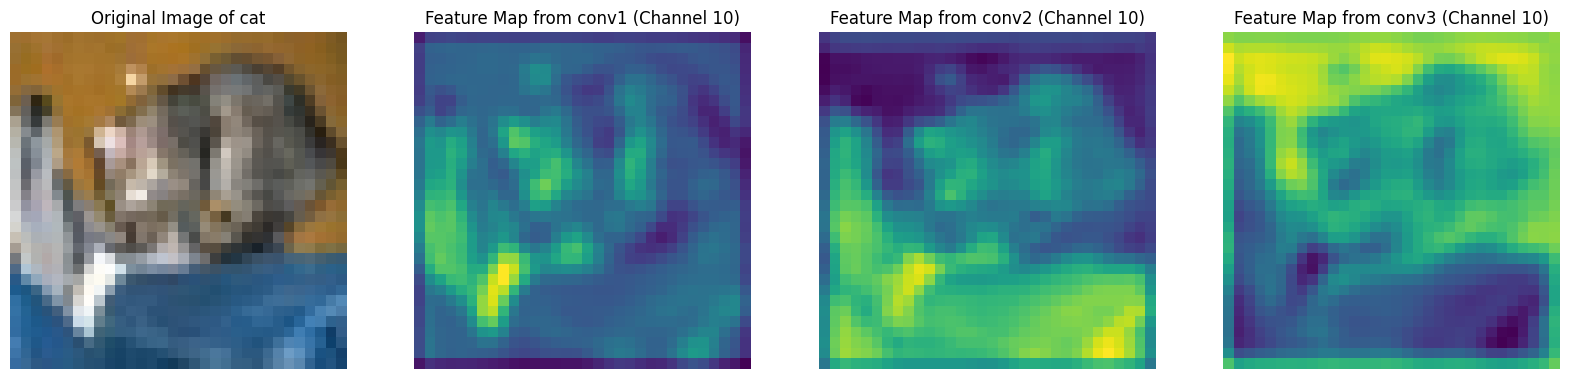

In [11]:
torch.manual_seed(42)

input_image = next(iter(test_dl))[0][0].to(device)
inp_label = next(iter(test_dl))[1][0].item()
inp_label = test_ds.classes[inp_label]

model.eval()
with torch.no_grad():
    conv1_output = model.conv1(input_image)  # Output of conv1
    conv2_output = model.conv2(conv1_output)  # Output of conv2
    conv3_output = model.conv3(conv2_output)  # Output of conv3

num_channels = conv1_output.shape[1]  
random_channel = torch.randint(0, num_channels, ()).item()

conv1_feature_map = conv1_output[random_channel].cpu().numpy()  
conv2_feature_map = conv2_output[random_channel].cpu().numpy()  
conv3_feature_map = conv3_output[random_channel].cpu().numpy()  

plt.figure(figsize=(20, 5))

# Plot the original image
plt.subplot(1, 4, 1)
plt.imshow(input_image.permute(1,2,0).cpu().numpy())
plt.title(f'Original Image of {inp_label}')
plt.axis('off')

# conv1 feature map
plt.subplot(1, 4, 2)
plt.imshow(conv1_feature_map, cmap='viridis')
plt.title(f'Feature Map from conv1 (Channel {random_channel})')
plt.axis('off')

# conv2 feature map
plt.subplot(1, 4, 3)
plt.imshow(conv2_feature_map, cmap='viridis')
plt.title(f'Feature Map from conv2 (Channel {random_channel})')
plt.axis('off')

# conv3 feature map
plt.subplot(1, 4, 4)
plt.imshow(conv3_feature_map, cmap='viridis')
plt.title(f'Feature Map from conv3 (Channel {random_channel})')
plt.axis('off')

plt.savefig('./task6_1.jpg')
plt.show()